<a href="https://colab.research.google.com/github/Marta54/Kaggle-Monet/blob/main/CycleGAN/CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

 from google.colab import files
 files.upload() #upload kaggle.json file (from the windows folder c:/user/.kaggle/)

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"msro111","key":"a81af7e0a53475599e8bb0c5b0046f28"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c gan-getting-started

100% 366M/367M [00:19<00:00, 21.1MB/s]
100% 367M/367M [00:19<00:00, 19.6MB/s]


In [ ]:
!unzip /content/gan-getting-started.zip 

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torch
import torch.nn as nn

from PIL import Image
import os
import matplotlib.pyplot as plt

In [7]:
batch_size = 1
learning_rate = 2e-4
lambda_cycle = 10
lambda_identity = 0.5 * lambda_cycle
num_workers = 2
num_epochs = 230
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
path = '/content/drive/MyDrive/Colab Notebooks/cGAN_monet_photo/'
n_photos = 2500

A cyclic GAN has two generators and two discriminators. One transforms an image in a domain, let's say, a Horse (X), into one in the second domain, let's say a Zebra (Y) (Gy) and the others does the opposite (Gx). As a result, there is also two discriminators. One that distinguishes if the generated horse is indistinguised from an horse (Dx) and the other does the same for the Zebra (Dy).

Besides the losses for theses networks, there is also a **cycle-consistency loss** allows the train os images not paired. This loss minimizes the reconstruction loss -> $ F(G(x))\approx X $ and $G(F(Y)) \approx Y $

We create an **identity-mapping loss** $\rightarrow$ when we send an image of an horse to the horse generator, nothing should happen (and same for the zebra). This enforces the model to keep similar colours. 

For each generator, we have the standard GAN loss (least sqr loss instead of BCE), the cyclic loss and the identity loss. We have two of each since we have two generators. The identity loss is not used in every dataset $\rightarrow$ it was used for the paining dataset tho. 

## Arquitecture
+ Generator
    + 2 downsamplings $\rightarrow$ stride 2
    + several residual blocks
    + 2 upsamplings $\rightarrow$  conv transposes
    + conv layer to RGB channels
+ Discriminator
    + 4 conv layers with stride 2 $\rightarrow$ patch GAN (cause we output a grid of values between 0 and 1 - patch of the original)
    
    


# Discriminator

In [8]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride, instanceNorm = 1):
        super().__init__()
        if instanceNorm:
            self.conv=nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size = 4, stride = stride, padding = 1, bias = True, padding_mode = "reflect"), #reflect reduces artifacts (paper)
                nn.InstanceNorm2d(out_channels),
                nn.LeakyReLU(0.2)
            )
            
        else:
            self.conv=nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size = 4, stride = stride, padding = 1, bias = True, padding_mode = "reflect"), #reflect reduces artifacts (paper)
                nn.LeakyReLU(0.2)
            )
        
    def forward(self,x):
        return self.conv(x) 
            
        

In [9]:
class Discriminator(nn.Module):
    def __init__(self, in_channels = 3, features = [64, 128, 256, 512], instanceNorm = 1):
        super().__init__()        
        layers = [Block(in_channels, features[0], stride = 2, instanceNorm = 0)]
            
        for i in range(1, len(features)):
            layers.append(Block(features[i - 1], features[i], stride = 1 if features[i] == features[-1] else 2))
            in_channels = features[i]
            
        # map to single value (real vs fake)
        layers.append(nn.Conv2d(in_channels, 1, kernel_size = 4, stride = 1, padding = 1, padding_mode = 'reflect'))
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return torch.sigmoid(self.model(x))

In [10]:
def test():
    x = torch.randn((5,3,256,256))
    model = Discriminator(in_channels = 3)
    preds = model(x)
    print(preds.shape)

test()

torch.Size([5, 1, 30, 30])


# Generator

In [11]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down = True, use_act = True, **kwargs): 
    # down - if it is down-sampling or up-sampling
    # use_act - if we use an activation

        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode = "reflect", **kwargs )
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs), #upsampling
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity()
        )
    
    def forward(self,x):
        return self.conv(x)
    
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size = 3, padding = 1),
            ConvBlock(channels, channels, use_act = False, kernel_size = 3, padding = 1),
        )

    def forward(self,x):
        return x + self.block(x)

In [12]:
class Generator(nn.Module):
    def __init__(self, img_channels, num_features = 64, num_residuals = 9):
        # num_residuals = 9 for >256x256; 6 for <128x128
        super().__init__()
        
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, 
                      num_features, 
                      kernel_size = 7,
                      stride = 1, 
                      padding = 3, 
                      padding_mode = "reflect"),
            # nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True)
        )
        
        self.down_block = nn.ModuleList(
        [
            ConvBlock(num_features,num_features * 2,down = True, kernel_size = 3, stride = 2, padding = 1),
            ConvBlock(num_features * 2,num_features * 4,down = True, kernel_size = 3, stride = 2, padding = 1)
            
        ])
        
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(num_features * 4) for _ in range(num_residuals)] # * for unwrapping the blocks
        )
        
        self.up_blocks = nn.ModuleList(
        [
            ConvBlock(num_features*4, num_features*2, down=False, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
            ConvBlock(num_features*2, num_features*1, down=False, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
        ])
        # converts to RGB
        self.last = nn.Conv2d(num_features, img_channels, kernel_size = 7, stride = 1, padding = 3, padding_mode = "reflect")
        
    def forward(self,x):
        x = self.initial(x)
        for layer in self.down_block:
            x = layer(x)
        x = self.residual_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
            
        return torch.tanh(self.last(x))      
        
        

In [13]:
def test_gen():
    img_channel = 3
    img_size = 256
    x = torch.randn((2,img_channel, img_size, img_size))
    gen = Generator(img_channel, 9)
    print(gen(x).shape)
    
test_gen()

torch.Size([2, 3, 256, 256])


# DataSet

In [14]:
# Create dataset

class Monet_Photo_Dataset(Dataset):
    def __init__(self,root_monet,root_photo,transform = None):
        self.root_monet = root_monet
        self.root_photo = root_photo
        self.transform = transform
        
        self.monet_images = os.listdir(root_monet)
        self.photo_images = os.listdir(root_photo)[:n_photos]
        self.length_dataset = max(len(self.monet_images),len(self.photo_images))
        self.photo_len = len(self.photo_images)
        self.monet_len = len(self.monet_images)
        
    def __len__(self):
        return self.length_dataset
    
    def __getitem__(self,index):
        photo_img = self.photo_images[index % self.photo_len]
        monet_img = self.monet_images[index % self.monet_len]
        
        monet_path = os.path.join(self.root_monet, monet_img)
        photo_path = os.path.join(self.root_photo, photo_img)
        
        monet = Image.open(monet_path).convert('RGB')
        photo = Image.open(photo_path).convert('RGB')
        
        if self.transform:
            monet = self.transform(monet)
            photo = self.transform(photo)
            
        monet = np.array(monet)
        photo = np.array(photo)
        
        return monet, photo

In [15]:
root_monet='/content/monet_jpg'
root_photo='/content/photo_jpg'

dataset = Monet_Photo_Dataset(
        root_monet,
        root_photo,
        transform = transforms.Compose([transforms.Resize(256),transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    )


# Training

In [16]:
def main(load_model = False):    
    D_monet = Discriminator(in_channels = 3)
    G_monet = Generator(img_channels = 3, num_residuals = 9)

    D_photo = Discriminator(in_channels = 3)
    G_photo = Generator(img_channels = 3, num_residuals = 9)
    
    if load_model:
        D_monet.load_state_dict(torch.load(path + 'discriminator_monet.pt',map_location=device))
        D_photo.load_state_dict(torch.load(path + 'discriminator_photo.pt',map_location=device))
        G_monet.load_state_dict(torch.load(path + 'generator_monet.pt',map_location=device))
        G_photo.load_state_dict(torch.load(path + 'generator_photo.pt',map_location=device))

    D_monet.to(device)
    G_monet.to(device)
    D_photo.to(device)
    G_photo.to(device)

    optimizer_D = optim.Adam(list(D_monet.parameters()) + list(D_photo.parameters()), 
                                lr = learning_rate,
                                betas = (0.5,0.999))
                            
    optimizer_G = optim.Adam(list(G_monet.parameters()) + list(G_photo.parameters()), 
                                lr = learning_rate,
                                betas = (0.5,0.999))

    L1 = nn.L1Loss()
    MSE = nn.MSELoss()
    
    loader = DataLoader(dataset,
                       batch_size = batch_size,
                       shuffle = True,
                       num_workers = num_workers,
                       pin_memory = True)
    
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()
    
    for epoch in range(num_epochs):
        print(f' Epoch: {epoch + 1}/{num_epochs}')
        
        train_epoch(D_monet,D_photo,
                   G_monet,G_photo,
                   loader,
                   optimizer_D, optimizer_G,
                    L1,
                    MSE,
                    d_scaler,g_scaler
                   )
        
        torch.save(G_monet.state_dict(), path + 'generator_monet.pt')
        torch.save(D_monet.state_dict(), path + 'discriminator_monet.pt')
        torch.save(D_photo.state_dict(), path + 'discriminator_photo.pt')
        torch.save(G_photo.state_dict(), path + 'generator_photo.pt')
            
            
def train_epoch(D_monet, D_photo, G_monet, G_photo, loader, optimizer_D, optimizer_G, L1, MSE, d_scaler, g_scaler):
    
    loop = tqdm(loader, leave = True)
    for idx, (monet, photo) in enumerate(loop):
        monet = monet.to(device)
        photo = photo.to(device)
        
        #Train D
        for _ in range(1):
            with torch.cuda.amp.autocast():
                # train monet discriminator
                fake_monet = G_monet(photo)
                D_monet_real = D_monet(monet)
                D_monet_fake = D_monet(fake_monet.detach())

                D_monet_real_loss = MSE(D_monet_real, torch.ones_like(D_monet_real))
                D_monet_fake_loss = MSE(D_monet_fake, torch.zeros_like(D_monet_fake))

                D_monet_loss = D_monet_real_loss + D_monet_fake_loss

                # train photo discriminator
                fake_photo = G_photo(monet)
                D_photo_real = D_photo(photo)
                D_photo_fake = D_photo(fake_photo.detach())

                D_photo_real_loss = MSE(D_photo_real, torch.ones_like(D_photo_real))
                D_photo_fake_loss = MSE(D_photo_fake, torch.zeros_like(D_photo_fake))

                D_photo_loss = D_photo_real_loss + D_photo_fake_loss

                D_loss = (D_monet_loss + D_photo_loss) / 2

            optimizer_D.zero_grad()
            d_scaler.scale(D_loss).backward()
            d_scaler.step(optimizer_D)
            d_scaler.update()
        
        # training the generators
        with torch.cuda.amp.autocast():
            # adversial loss
            D_monet_fake = D_monet(fake_monet)
            D_photo_fake = D_photo(fake_photo)
            loss_G_monet = MSE(D_monet_fake, torch.ones_like(D_monet_fake))
            loss_G_photo = MSE(D_photo_fake, torch.ones_like(D_photo_fake))
            
            # cycle loss
            cycle_monet = G_monet(fake_photo) #this should give the original Monet
            cycle_photo = G_photo(fake_monet) #this should give the original photo
            
            cycle_monet_loss = L1(monet, cycle_monet)
            cycle_photo_loss = L1(photo, cycle_photo)
            
            # identity loss
            identity_monet = G_monet(monet)
            identity_photo = G_photo(photo)
            
            identity_monet_loss = L1(monet,identity_monet)
            identity_photo_loss = L1(photo,identity_photo)

            
            # add all together
            G_loss = (loss_G_monet + loss_G_photo
                      + cycle_monet_loss * lambda_cycle
                      + cycle_photo_loss * lambda_cycle
                      + identity_monet_loss * lambda_identity
                      + identity_photo_loss * lambda_identity
                     )
            
        optimizer_G.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(optimizer_G)
        g_scaler.update()
        
        if idx % 300 == 0:
            print(f'Discriminator Loss: {D_loss} | Generator Loss: {G_loss}')
            w = 60
            fig = plt.figure(figsize=(w/4,w))
            plt.subplot(1,4,1)
            plt.imshow(monet.squeeze().cpu().detach().numpy().transpose(1,2,0) * 0.5 + 0.5)
            plt.title('Original Monet')
            plt.subplot(1,4,2)
            f_p = fake_photo.squeeze().cpu().detach().numpy().transpose(1,2,0) * 0.5 + 0.5 
            plt.imshow(f_p.astype(np.float32))
            plt.title('Fake photo')
            plt.subplot(1,4,3)
            plt.imshow(photo.squeeze().cpu().detach().numpy().transpose(1,2,0) * 0.5 + 0.5)
            plt.title('Original Photo')
            plt.subplot(1,4,4)
            f_m = fake_monet.squeeze().cpu().detach().numpy().transpose(1,2,0) * 0.5 + 0.5
            plt.imshow(f_m.astype(np.float32))
            plt.title('Fake Monet')
           
            
            plt.subplots_adjust(hspace=0.2, wspace=0.2)
            plt.show()
            
            # torch.save(G_monet.state_dict(), path + 'generator_monet.pt')
            # torch.save(D_monet.state_dict(), path + 'discriminator_monet.pt')
            # torch.save(D_photo.state_dict(), path + 'discriminator_photo.pt')
            # torch.save(G_photo.state_dict(), path + 'generator_photo.pt')
            
            
            
            
        
            
    
    

 Epoch: 1/230


  0%|          | 0/2500 [00:00<?, ?it/s]

Discriminator Loss: 0.1550365537405014 | Generator Loss: 2.9541478157043457


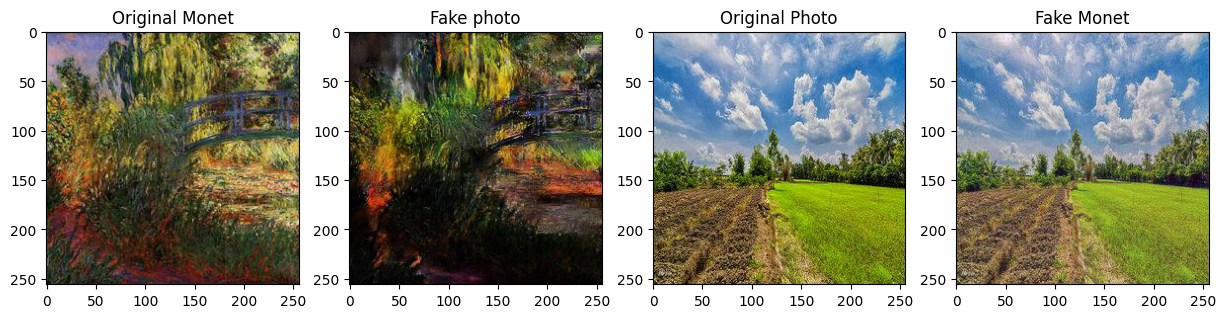

 12%|█▏        | 300/2500 [01:16<09:03,  4.05it/s]

Discriminator Loss: 0.21926796436309814 | Generator Loss: 2.5595133304595947


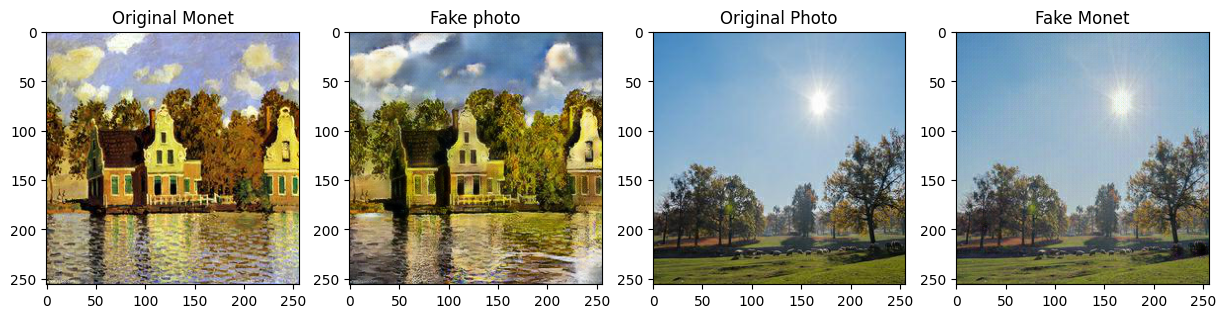

 24%|██▍       | 600/2500 [02:32<08:12,  3.85it/s]

Discriminator Loss: 0.208746537566185 | Generator Loss: 2.5772221088409424


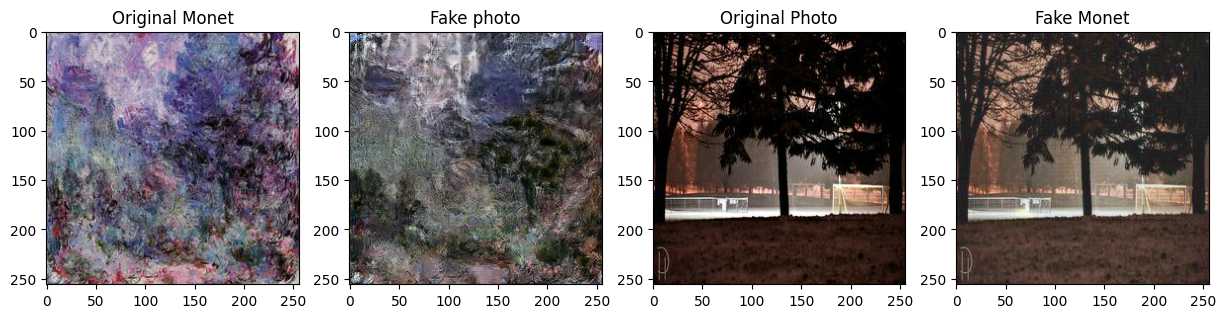

 36%|███▌      | 900/2500 [03:49<06:37,  4.03it/s]

Discriminator Loss: 0.3676922023296356 | Generator Loss: 2.4224445819854736


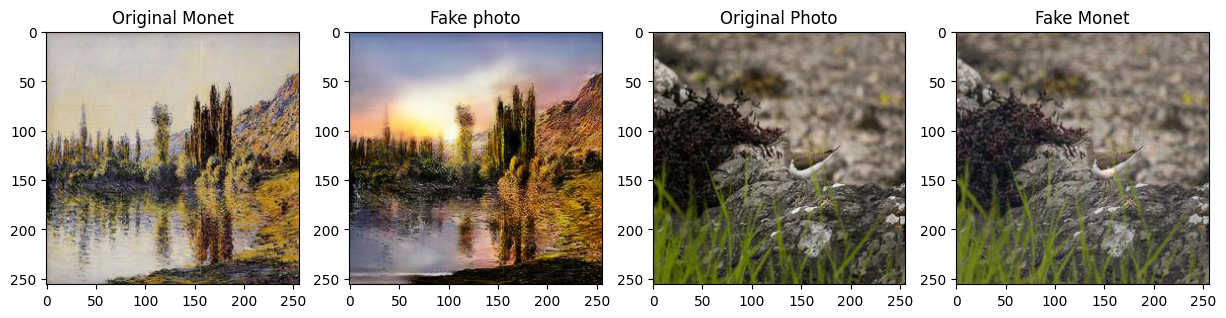

 48%|████▊     | 1200/2500 [05:06<05:36,  3.86it/s]

Discriminator Loss: 0.3046919107437134 | Generator Loss: 2.375760078430176


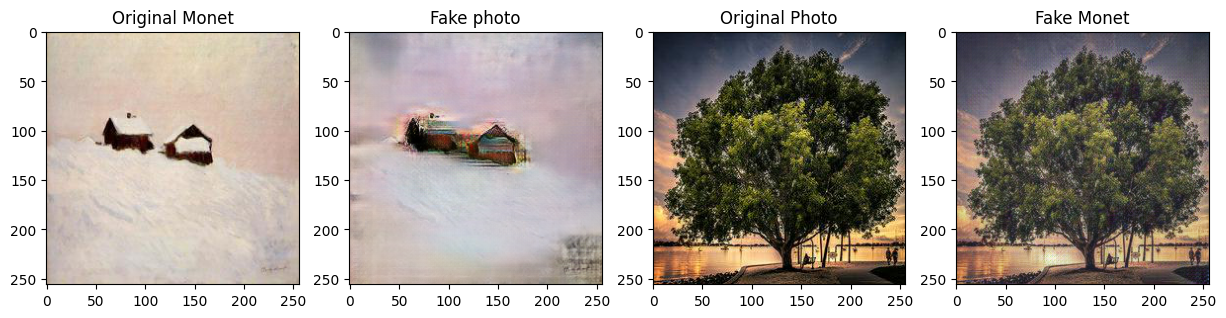

 55%|█████▍    | 1363/2500 [05:48<05:03,  3.74it/s]

In [ ]:

main(load_model = True)